In [2]:
import numpy as np
import pandas as pd

import nibabel as nib
import os
import cv2

from scipy.sparse import csr_array
from scipy.sparse.csgraph import connected_components

import matplotlib.pyplot as plt

In [ ]:
pred_folder_ensemble = "<PATH_TO_PRED_ENSEMBLE_FOLDER>"
true_folder_test = "<PATH_TO_TRUE_LABELS_TS_FOLDER>"
image_folder = "<PATH_TO_IMAGES_TS_FOLDER>"
TEST_df = pd.read_csv("<PATH_TO_TEST_CSV>")
N_test = len(TEST_df)


In [10]:
def get_cs_cc(input_slice):
    image = np.array(input_slice, dtype=np.uint8)
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(image)
    return labels, centroids
            
        
        
def calculate_slice_all_labels_dice_score(segmentation, truth, label):
    segmentation = np.where(segmentation == label, 1, 0)
    truth = np.where(truth == label, 1, 0)
    area_sum = np.sum(segmentation) + np.sum(truth)
    if area_sum > 0:
        return np.sum(segmentation[truth==1])*2.0 / area_sum
    else:
        return 1

In [18]:
image_dir = "./cc2d"
counter = 0

cc_list = ["C2/C3", "C3/C4", "C4/C5", "C5/C6", "C6/C7", "C7/T1"]

for i in range(N_test):
    fname = "cspine_%d.nii.gz" % i
    true_seg = nib.load(os.path.join(true_folder_test, fname)).get_fdata()
    pred_seg = nib.load(os.path.join(pred_folder_ensemble, fname)).get_fdata()
    image = nib.load(os.path.join(image_folder, "cspine_%d_0000.nii.gz" % i)).get_fdata()
    
    shape = true_seg.shape
    # first, get binarized IVD labels
    true_ivd = np.where(true_seg == 2, 1, 0)
    true_middle_slice = true_ivd[:, :, shape[-1] // 2]

    pred_ivd = np.where(pred_seg == 2, 1, 0)
    pred_middle_slice = pred_ivd[:, :, shape[-1] // 2]
    
    # second, get labels for each IVD in cervical spine region
    true_ivd_labels, true_ivd_centroids = get_cs_cc(true_middle_slice)
    pred_ivd_labels, pred_ivd_centroids = get_cs_cc(pred_middle_slice)
    
    plt.imshow(image[:,:,shape[-1] // 2], cmap='gray')
    plt.imshow(true_ivd_labels, alpha=0.7, cmap = 'magma')
    sorted_arr_desc = true_ivd_centroids[1:][true_ivd_centroids[1:][:, 0].argsort()[::-1]]
    for idx, c in enumerate(sorted_arr_desc):
        # plt.scatter(c[0], c[1], color="r", s=5)
        if idx < len(cc_list):
            plt.text(c[0], c[1], cc_list[idx], fontsize=4, color='red', ha='center', va='bottom', fontweight='bold')
    plt.savefig(os.path.join(image_dir, "cspine_%d_TRUE.png" % i), dpi=300)
    # plt.savefig(os.path.join(image_dir, "true", "true_cspine_%d.png" % i))
    plt.close()
    
    plt.imshow(image[:,:,shape[-1] // 2], cmap='gray')
    plt.imshow(pred_ivd_labels, alpha=0.7, cmap = 'magma')
    sorted_arr_desc = pred_ivd_centroids[1:][pred_ivd_centroids[1:][:, 0].argsort()[::-1]]
    # print("centroids for pred", sorted_arr_desc)
    for idx, c in enumerate(sorted_arr_desc):
        if idx < len(cc_list):
            plt.text(c[0], c[1], cc_list[idx], fontsize=4, color='red', ha='center', va='bottom', fontweight='bold')
    plt.savefig(os.path.join(image_dir, "cspine_%d_PRED.png" % i), dpi=300)
    # plt.savefig(os.path.join(image_dir, "pred", "pred_cspine_%d.png" % i))
    plt.close()
    
    # if counter > 4:
    #     break
    # counter += 1
    # break

In [165]:
sort_index = true_ivd_centroids[1:][:, 0].argsort()[::-1]
sort_index

array([0, 1, 2, 3, 4, 5, 6, 7, 8])

In [54]:
# case_exclude = [28, 36, 53, 57, 58, 59, 68, 74, 76, 82, 92, 93]
case_exclude = [14, 28, 36, 53, 57, 58, 59, 68, 74, 76, 82, 92, 93]
print(f"number of cases included in the CC analysis: {len(TEST_df) - len(case_exclude)}")

number of cases included in the CC analysis: 87


In [55]:
N_test = len(TEST_df)
cc_list = ["C2/C3", "C3/C4", "C4/C5", "C5/C6", "C6/C7", "C7/T1"]

res_dict = {x:[] for x in cc_list}
for i in range(N_test):
    if i in case_exclude:
        continue
        # for j in range(6):
        #     cs_level = cc_list[j]
        #     res_dict[cs_level].append(np.nan)
    else:            
        fname = "cspine_%d.nii.gz" % i
        true_seg = nib.load(os.path.join(true_folder_test, fname)).get_fdata()
        pred_seg = nib.load(os.path.join(pred_folder_ensemble, fname)).get_fdata()

        shape = true_seg.shape

        true_ivd = np.where(true_seg == 2, 1, 0)
        true_middle_slice = true_ivd[:, :, shape[-1] // 2]

        pred_ivd = np.where(pred_seg == 2, 1, 0)
        pred_middle_slice = pred_ivd[:, :, shape[-1] // 2]

        true_ivd_labels, true_ivd_centroids = get_cs_cc(true_middle_slice)
        pred_ivd_labels, pred_ivd_centroids = get_cs_cc(pred_middle_slice)



        true_sorted_arr_desc = true_ivd_centroids[1:][:, 0].argsort()[::-1]
        pred_sorted_arr_desc = pred_ivd_centroids[1:][:, 0].argsort()[::-1]
        # print("====>", true_sorted_arr_desc, pred_sorted_arr_desc)


        if len(true_ivd_centroids)<7 or len(pred_ivd_centroids) < 7:
            print(f"incompatible shape of cc result for the case: {fname}")
            continue

        label_value = 1

        for j in range(6):
            true_labelvalue, pred_labelvalue = true_sorted_arr_desc[j], pred_sorted_arr_desc[j]
            true_ivd_labels_bin = np.where(true_ivd_labels==true_labelvalue+1, 1, 0)
            pred_ivd_labels_bin = np.where(pred_ivd_labels==pred_labelvalue+1, 1, 0)
            dice = calculate_slice_all_labels_dice_score(pred_ivd_labels_bin, true_ivd_labels_bin, 1)
            cs_level = cc_list[j]
            res_dict[cs_level].append(dice)
            if dice<0.3:
                print(f"dice is 0 on {cs_level}: {fname}")
        

    # break

dice is 0 on C5/C6: cspine_42.nii.gz


In [58]:
for cc in cc_list:
    print(len(res_dict[cc]))
    print(f"""For {cc}, mean dice is: {np.nanmean(res_dict[cc]):.3f} with sd: {np.nanstd(res_dict[cc]):.3f}, max--min: {max(res_dict[cc])}--{min(res_dict[cc])}""")

87
For C2/C3, mean dice is: 0.915 with sd: 0.040, max--min: 0.9750889679715302--0.7695238095238095
87
For C3/C4, mean dice is: 0.900 with sd: 0.067, max--min: 0.9635036496350365--0.47904191616766467
87
For C4/C5, mean dice is: 0.894 with sd: 0.052, max--min: 0.9632107023411371--0.6961325966850829
87
For C5/C6, mean dice is: 0.871 with sd: 0.097, max--min: 0.9903536977491961--0.1935483870967742
87
For C6/C7, mean dice is: 0.879 with sd: 0.078, max--min: 0.9798270893371758--0.4125874125874126
87
For C7/T1, mean dice is: 0.907 with sd: 0.054, max--min: 0.9699248120300752--0.7058823529411765


In [52]:
for cc in cc_list:
    print(len(res_dict[cc]))
    print(f"""For {cc}, mean dice is: {np.nanmean(res_dict[cc])} with sd: {np.nanstd(res_dict[cc])}, max--min: {max(res_dict[cc])}--{min(res_dict[cc])}""")

86
For C2/C3, mean dice is: 0.9149499238716486 with sd: 0.03966820736958468, max--min: 0.9750889679715302--0.7695238095238095
86
For C3/C4, mean dice is: 0.9014199277137802 with sd: 0.0661928695597773, max--min: 0.9635036496350365--0.47904191616766467
86
For C4/C5, mean dice is: 0.8934553742346089 with sd: 0.05210635532285822, max--min: 0.9632107023411371--0.6961325966850829
86
For C5/C6, mean dice is: 0.8791812153588353 with sd: 0.06423668957864732, max--min: 0.9903536977491961--0.6347305389221557
86
For C6/C7, mean dice is: 0.8792708127512437 with sd: 0.07869871497063986, max--min: 0.9798270893371758--0.4125874125874126
86
For C7/T1, mean dice is: 0.9071344681178384 with sd: 0.05449893361444294, max--min: 0.9699248120300752--0.7058823529411765


In [57]:
from scipy.stats import mannwhitneyu
for i in range(6):
    for j in range(i, 6):
        score1 = res_dict[cc_list[i]]
        score2 = res_dict[cc_list[j]]
        _, pval = mannwhitneyu(score1, score2)
        print(f"{cc_list[i]} vs {cc_list[j]}, test p value: {pval:.3f}")
        if pval < 0.05:
            print(f">>>>>>>>>>>>>>>>>>>> Significant: {cc_list[i]} vs {cc_list[j]}")


C2/C3 vs C2/C3, test p value: 1.000
C2/C3 vs C3/C4, test p value: 0.213
C2/C3 vs C4/C5, test p value: 0.002
>>>>>>>>>>>>>>>>>>>> Significant: C2/C3 vs C4/C5
C2/C3 vs C5/C6, test p value: 0.000
>>>>>>>>>>>>>>>>>>>> Significant: C2/C3 vs C5/C6
C2/C3 vs C6/C7, test p value: 0.000
>>>>>>>>>>>>>>>>>>>> Significant: C2/C3 vs C6/C7
C2/C3 vs C7/T1, test p value: 0.703
C3/C4 vs C3/C4, test p value: 1.000
C3/C4 vs C4/C5, test p value: 0.083
C3/C4 vs C5/C6, test p value: 0.003
>>>>>>>>>>>>>>>>>>>> Significant: C3/C4 vs C5/C6
C3/C4 vs C6/C7, test p value: 0.017
>>>>>>>>>>>>>>>>>>>> Significant: C3/C4 vs C6/C7
C3/C4 vs C7/T1, test p value: 0.404
C4/C5 vs C4/C5, test p value: 1.000
C4/C5 vs C5/C6, test p value: 0.133
C4/C5 vs C6/C7, test p value: 0.369
C4/C5 vs C7/T1, test p value: 0.010
>>>>>>>>>>>>>>>>>>>> Significant: C4/C5 vs C7/T1
C5/C6 vs C5/C6, test p value: 1.000
C5/C6 vs C6/C7, test p value: 0.529
C5/C6 vs C7/T1, test p value: 0.000
>>>>>>>>>>>>>>>>>>>> Significant: C5/C6 vs C7/T1
C6/C7 vs 

In [53]:
from scipy.stats import mannwhitneyu
for i in range(6):
    for j in range(i, 6):
        score1 = res_dict[cc_list[i]]
        score2 = res_dict[cc_list[j]]
        _, pval = mannwhitneyu(score1, score2)
        print(f"{cc_list[i]} vs {cc_list[j]}, test p value: {pval:.3f}")
        if pval < 0.05:
            print(f">>>>>>>>>>>>>>>>>>>> Significant: {cc_list[i]} vs {cc_list[j]}")

C2/C3 vs C2/C3, test p value: 1.000
C2/C3 vs C3/C4, test p value: 0.296
C2/C3 vs C4/C5, test p value: 0.003
>>>>>>>>>>>>>>>>>>>> Significant: C2/C3 vs C4/C5
C2/C3 vs C5/C6, test p value: 0.000
>>>>>>>>>>>>>>>>>>>> Significant: C2/C3 vs C5/C6
C2/C3 vs C6/C7, test p value: 0.001
>>>>>>>>>>>>>>>>>>>> Significant: C2/C3 vs C6/C7
C2/C3 vs C7/T1, test p value: 0.757
C3/C4 vs C3/C4, test p value: 1.000
C3/C4 vs C4/C5, test p value: 0.062
C3/C4 vs C5/C6, test p value: 0.003
>>>>>>>>>>>>>>>>>>>> Significant: C3/C4 vs C5/C6
C3/C4 vs C6/C7, test p value: 0.014
>>>>>>>>>>>>>>>>>>>> Significant: C3/C4 vs C6/C7
C3/C4 vs C7/T1, test p value: 0.472
C4/C5 vs C4/C5, test p value: 1.000
C4/C5 vs C5/C6, test p value: 0.172
C4/C5 vs C6/C7, test p value: 0.400
C4/C5 vs C7/T1, test p value: 0.011
>>>>>>>>>>>>>>>>>>>> Significant: C4/C5 vs C7/T1
C5/C6 vs C5/C6, test p value: 1.000
C5/C6 vs C6/C7, test p value: 0.599
C5/C6 vs C7/T1, test p value: 0.001
>>>>>>>>>>>>>>>>>>>> Significant: C5/C6 vs C7/T1
C6/C7 vs 

In [89]:
def get_cs_cc(input_slice):
    image = np.array(input_slice, dtype=np.uint8)
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(image)
    return labels, centroids
            
        
        
def calculate_slice_all_labels_dice_score(segmentation, truth, label):
    segmentation = np.where(segmentation == label, 1, 0)
    truth = np.where(truth == label, 1, 0)
    area_sum = np.sum(segmentation) + np.sum(truth)
    if area_sum > 0:
        return np.sum(segmentation[truth==1])*2.0 / area_sum
    else:
        return 1

In [103]:
shape = true_seg.shape

true_ivd = np.where(true_seg == 2, 1, 0)
true_middle_slice = true_ivd[:, :, shape[-1] // 2]

pred_ivd = np.where(pred_seg == 2, 1, 0)
pred_middle_slice = pred_ivd[:, :, shape[-1] // 2]

cc_list = ["C2", "C3", "C4", "C5", "C6", "C7"]
true_ivd_labels, true_ivd_centroids = get_cs_cc(true_middle_slice)
pred_ivd_labels, pred_ivd_centroids = get_cs_cc(pred_middle_slice)

res_dict = {x:[] for x in cc_list}
label_value = 1
for cs_level in cc_list:
    dice = calculate_slice_all_labels_dice_score(pred_ivd_labels, true_ivd_labels, label_value)
    label_value += 1
    res_dict[cs_level].append(dice)
        

In [104]:
res_dict

{'C2': [0.8632218844984803],
 'C3': [0.47904191616766467],
 'C4': [0.6961325966850829],
 'C5': [0.8111455108359134],
 'C6': [0.7853107344632768],
 'C7': [0.7899686520376176]}

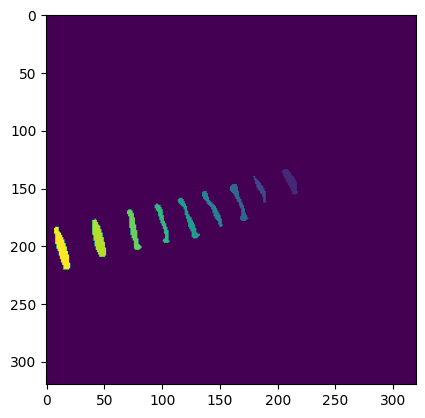

In [98]:
plt.imshow(pred_vb_labels)


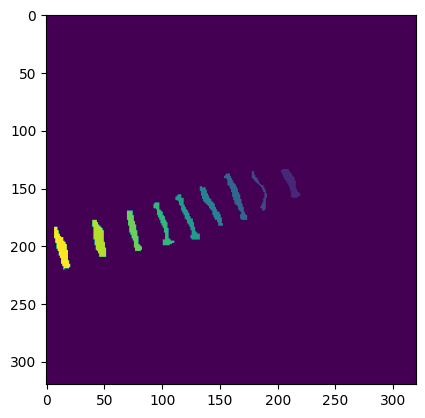

In [99]:
plt.imshow(true_vb_labels)

In [67]:
shape = true_seg.shape

true_vb = np.where(true_seg == 1, 1, 0)
true_middle_slice = true_vb[:, :, shape[-1] // 2]



pred_vb = np.where(pred_seg == 1, 1, 0)
pred_middle_slice = pred_vb[:, :, shape[-1] // 2]


# plt.imshow(middle_slice)

In [44]:
# Create a sample binary image
image = np.array(middle_slice, dtype=np.uint8)

# Apply connected component labeling
num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(image)

In [45]:
print(f"Number of connected components: {num_labels - 1}") # Subtract 1 for background
print(f"Labels of connected components:\n{labels}")

Number of connected components: 10
Labels of connected components:
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [64]:
np.unique(labels)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=int32)

In [48]:
centroids

array([[162.49091574, 158.54324692],
       [232.14542936, 141.57479224],
       [174.73353752, 153.67534456],
       [196.19833333, 149.52666667],
       [153.38215488, 161.80639731],
       [131.84325109, 169.74165457],
       [111.13578275, 176.94089457],
       [ 87.96338028, 182.44788732],
       [ 60.40677966, 188.80312907],
       [ 28.42243187, 197.28406709],
       [  4.86823529, 206.77882353]])

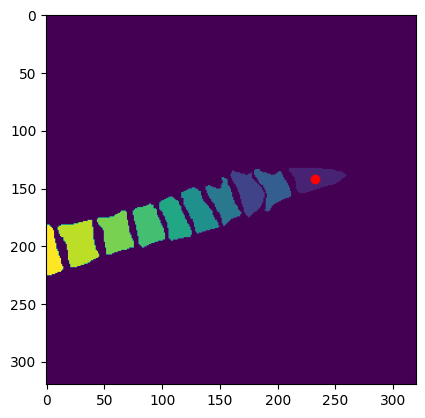

In [61]:
plt.imshow(labels)
for c in centroids[1:]:
    plt.scatter(c[0], c[1], color="r")
    break
plt.show()

In [62]:
sorted_arr_desc = centroids[1:][centroids[1:][:, 0].argsort()[::-1]]

In [63]:
sorted_arr_desc

array([[232.14542936, 141.57479224],
       [196.19833333, 149.52666667],
       [174.73353752, 153.67534456],
       [153.38215488, 161.80639731],
       [131.84325109, 169.74165457],
       [111.13578275, 176.94089457],
       [ 87.96338028, 182.44788732],
       [ 60.40677966, 188.80312907],
       [ 28.42243187, 197.28406709],
       [  4.86823529, 206.77882353]])

In [59]:
review = pd.read_excel("./cc2d_sus/EC-notes-8-18-25.xlsx")

In [60]:
review

,Case,Pred,True,Note
0,28,x,x,"Multiple fused bodies, both wrong"
1,36,o,x,True assigns two levels to same disc
2,53,x,x,"6/7 bodies are fused, both wrong"
3,57,o,x,"Partial fusion 5-7, pred is correct"
4,58,x,x,"5-7 fused, both wrong"
5,59,x,x,"6-7 fused, both wrong"
6,68,o,x,"5-6 partial fusion, pred is correct"
7,74,x,x,"4-6 fused, both wrong"
8,76,x,x,"5-6 fused, both wrong"
9,82,o,x,"Oblique slice, no 7/1 disc space visible, 6/7 ..."
